In [ ]:
! nvidia-smi

In [ ]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw12

In [ ]:
! pip install -q -r requirements.txt

In [1]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [5]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from utils.hw12_utils import q12_results
from semisupervised.vat import VAT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [10]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128)

    vat = VAT(10, device, latent_dim=12)
    return vat.fit(train_dataloader, test_dataloader, n_epochs=1)

Files already downloaded and verified
Files already downloaded and verified
Start test score: 12.658227848101266


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Test score after epoch 1: 24.126582278481013


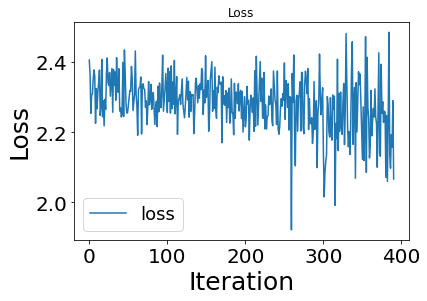

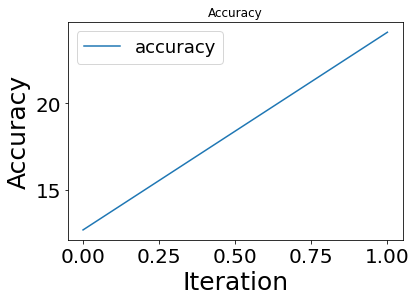

In [11]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    pass

In [ ]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    pass